## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        trace_df=trace_df.drop(['wifi_val1'], axis=1)
        trace_df=trace_df.drop(['wifi_val2'], axis=1)
        trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#1 trace test Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/test/'
trace_values=(convert_to_df(file_path,0))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
len(sequences)

98

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,10))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
waypoint_sequence[0]

[198.4250223619632,
 163.5077047852761,
 198.48171472392636,
 198.36833,
 163.52063,
 163.49477957055217]

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 2197
Number of targets 2197
Number of timeslots in first sequence 100
Number of timeslots in tenth sequence 100
Number of timeslots in hundredth sequence 100


In [ ]:
#Now adding data of other floors to the sequences starting with F1
file_path = '/content/drive/MyDrive/building1/data/F1'
trace_values=(convert_to_df(file_path,1,10))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F2'
trace_values=(convert_to_df(file_path,2,10))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F3'
trace_values=(convert_to_df(file_path,3,10))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
file_path = '/content/drive/MyDrive/building1/data/F4'
trace_values=(convert_to_df(file_path,4,10))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 113047
Number of targets 113047
Number of timeslots in first sequence 10
Number of timeslots in tenth sequence 10
Number of timeslots in hundredth sequence 10


In [ ]:
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)
flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

113047

In [ ]:
train = [sequences[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)
#normalise the target values
train_target = np.array(train_target)
#train_target = (train_target)/4
train_target=to_categorical(train_target,num_classes = 5)

validation_target = np.array(validation_target)
#validation_target = (validation_target)/4
validation_target=to_categorical(validation_target,num_classes = 5)

test_target = np.array(test_target)
#test_target = (test_target)/4
test_target=to_categorical(test_target,num_classes = 5)

In [ ]:
print(sequences[0].shape)
train_target.shape

(10, 24)


(79132, 5)

In [ ]:
seq_len = 10
seq_bredth=24
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, seq_bredth)))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               287744    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 321,285
Trainable params: 321,285
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Extra
def show_shapes(): # can make yours to take inputs; this'll use local variable values
    print("Expected: (num_samples, timesteps, channels)")
    print("Sequences: {}".format(Sequences.shape))
    print("Targets:   {}".format(Targets.shape))

In [ ]:
#Extra
Sequences = np.asarray(train)
Targets   = np.asarray(train_target)
show_shapes()

Sequences = np.expand_dims(train, -1)
Targets   = np.expand_dims(train_target, -1)
show_shapes()

Expected: (num_samples, timesteps, channels)
Sequences: (360, 200, 26)
Targets:   (77,)
Expected: (num_samples, timesteps, channels)
Sequences: (360, 200, 26, 1)
Targets:   (77, 1)


In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)



In [ ]:
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
619/619 [==============================] - 68s 107ms/step - loss: 0.6473 - accuracy: 0.7001 - val_loss: 0.3486 - val_accuracy: 0.8470

Epoch 00001: val_accuracy improved from -inf to 0.84697, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 2/200
619/619 [==============================] - 69s 111ms/step - loss: 0.3361 - accuracy: 0.8447 - val_loss: 0.3183 - val_accuracy: 0.8682

Epoch 00002: val_accuracy improved from 0.84697 to 0.86820, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 3/200
619/619 [==============================] - 64s 104ms/step - loss: 0.3076 - accuracy: 0.8559 - val_loss: 0.2805 - val_accuracy: 0.8807

Epoch 00003: val_accuracy improved from 0.86820 to 0.88070, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 4/200
619/619 [==============================] - 61s 98ms/step - loss: 0.2720 - accuracy: 0.8717 - val_loss: 0.2836 - val_accuracy: 0.8695

Epoch 00004: val_accuracy did not improve from 0.88070
Epoch 5/200
619/619 [==============================] - 54s 87ms/step - loss: 0.2474 - accuracy: 0.8813 - val_loss: 0.2250 - val_accuracy: 0.8912

Epoch 00005: val_accuracy improved from 0.88070 to 0.89120, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 6/200
619/619 [==============================] - 68s 110ms/step - loss: 0.2634 - accuracy: 0.8759 - val_loss: 0.1961 - val_accuracy: 0.9084

Epoch 00006: val_accuracy improved from 0.89120 to 0.90836, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 7/200
619/619 [==============================] - 67s 108ms/step - loss: 0.2292 - accuracy: 0.8935 - val_loss: 0.1903 - val_accuracy: 0.9125

Epoch 00007: val_accuracy improved from 0.90836 to 0.91254, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 8/200
619/619 [==============================] - 66s 107ms/step - loss: 0.2144 - accuracy: 0.8996 - val_loss: 0.2436 - val_accuracy: 0.8844

Epoch 00008: val_accuracy did not improve from 0.91254
Epoch 9/200
619/619 [==============================] - 66s 106ms/step - loss: 0.2150 - accuracy: 0.9021 - val_loss: 0.1937 - val_accuracy: 0.9110

Epoch 00009: val_accuracy did not improve from 0.91254
Epoch 10/200
619/619 [==============================] - 63s 102ms/step - loss: 0.1804 - accuracy: 0.9173 - val_loss: 0.2072 - val_accuracy: 0.9081

Epoch 00010: val_accuracy did not improve from 0.91254
Epoch 11/200
619/619 [==============================] - 64s 103ms/step - loss: 0.1791 - accuracy: 0.9185 - val_loss: 0.3107 - val_accuracy: 0.8815

Epoch 00011: val_accuracy did not improve from 0.91254
Epoch 12/200
619/619 [==============================] - 69s 111ms/step - loss: 0.1809 - accuracy: 0.9193 - val_loss: 0.1653 - val_accuracy: 0.9121

Epoch 00012: val_accuracy did not improve 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 14/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1587 - accuracy: 0.9304 - val_loss: 0.2489 - val_accuracy: 0.8964

Epoch 00014: val_accuracy did not improve from 0.95288
Epoch 15/200
619/619 [==============================] - 57s 92ms/step - loss: 0.1517 - accuracy: 0.9372 - val_loss: 0.1259 - val_accuracy: 0.9500

Epoch 00015: val_accuracy did not improve from 0.95288
Epoch 16/200
619/619 [==============================] - 58s 94ms/step - loss: 0.1364 - accuracy: 0.9400 - val_loss: 0.1113 - val_accuracy: 0.9554

Epoch 00016: val_accuracy improved from 0.95288 to 0.95542, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 17/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1228 - accuracy: 0.9485 - val_loss: 0.1687 - val_accuracy: 0.9208

Epoch 00017: val_accuracy did not improve from 0.95542
Epoch 18/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1436 - accuracy: 0.9395 - val_loss: 0.1330 - val_accuracy: 0.9456

Epoch 00018: val_accuracy did not improve from 0.95542
Epoch 19/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1587 - accuracy: 0.9324 - val_loss: 0.1426 - val_accuracy: 0.9338

Epoch 00019: val_accuracy did not improve from 0.95542
Epoch 20/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1225 - accuracy: 0.9468 - val_loss: 0.1274 - val_accuracy: 0.9424

Epoch 00020: val_accuracy did not improve from 0.95542
Epoch 21/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1355 - accuracy: 0.9440 - val_loss: 0.1309 - val_accuracy: 0.9445

Epoch 00021: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 24/200
619/619 [==============================] - 65s 105ms/step - loss: 0.1273 - accuracy: 0.9476 - val_loss: 0.1007 - val_accuracy: 0.9601

Epoch 00024: val_accuracy did not improve from 0.96385
Epoch 25/200
619/619 [==============================] - 67s 109ms/step - loss: 0.1277 - accuracy: 0.9490 - val_loss: 0.2546 - val_accuracy: 0.8828

Epoch 00025: val_accuracy did not improve from 0.96385
Epoch 26/200
619/619 [==============================] - 67s 108ms/step - loss: 0.1492 - accuracy: 0.9386 - val_loss: 0.1236 - val_accuracy: 0.9431

Epoch 00026: val_accuracy did not improve from 0.96385
Epoch 27/200
619/619 [==============================] - 68s 109ms/step - loss: 0.1232 - accuracy: 0.9477 - val_loss: 0.0839 - val_accuracy: 0.9709

Epoch 00027: val_accuracy improved from 0.96385 to 0.97093, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 28/200
619/619 [==============================] - 67s 107ms/step - loss: 0.0877 - accuracy: 0.9652 - val_loss: 0.3069 - val_accuracy: 0.8671

Epoch 00028: val_accuracy did not improve from 0.97093
Epoch 29/200
619/619 [==============================] - 68s 109ms/step - loss: 0.1943 - accuracy: 0.9169 - val_loss: 0.1223 - val_accuracy: 0.9495

Epoch 00029: val_accuracy did not improve from 0.97093
Epoch 30/200
619/619 [==============================] - 73s 118ms/step - loss: 0.1169 - accuracy: 0.9507 - val_loss: 0.0971 - val_accuracy: 0.9587

Epoch 00030: val_accuracy did not improve from 0.97093
Epoch 31/200
619/619 [==============================] - 70s 113ms/step - loss: 0.1264 - accuracy: 0.9488 - val_loss: 0.0925 - val_accuracy: 0.9603

Epoch 00031: val_accuracy did not improve from 0.97093
Epoch 32/200
619/619 [==============================] - 69s 112ms/step - loss: 0.1024 - accuracy: 0.9593 - val_loss: 0.0833 - val_accuracy: 0.9721

Epoch 00032: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 33/200
619/619 [==============================] - 71s 114ms/step - loss: 0.0935 - accuracy: 0.9631 - val_loss: 0.1402 - val_accuracy: 0.9335

Epoch 00033: val_accuracy did not improve from 0.97211
Epoch 34/200
619/619 [==============================] - 70s 113ms/step - loss: 0.1022 - accuracy: 0.9587 - val_loss: 0.2655 - val_accuracy: 0.9067

Epoch 00034: val_accuracy did not improve from 0.97211
Epoch 35/200
619/619 [==============================] - 72s 116ms/step - loss: 0.1419 - accuracy: 0.9484 - val_loss: 0.0603 - val_accuracy: 0.9755

Epoch 00035: val_accuracy improved from 0.97211 to 0.97547, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 36/200
619/619 [==============================] - 67s 109ms/step - loss: 0.1206 - accuracy: 0.9500 - val_loss: 0.2549 - val_accuracy: 0.8978

Epoch 00036: val_accuracy did not improve from 0.97547
Epoch 37/200
619/619 [==============================] - 70s 114ms/step - loss: 0.0978 - accuracy: 0.9637 - val_loss: 0.1015 - val_accuracy: 0.9529

Epoch 00037: val_accuracy did not improve from 0.97547
Epoch 38/200
619/619 [==============================] - 68s 110ms/step - loss: 0.1135 - accuracy: 0.9524 - val_loss: 0.0853 - val_accuracy: 0.9558

Epoch 00038: val_accuracy did not improve from 0.97547
Epoch 39/200
619/619 [==============================] - 60s 97ms/step - loss: 0.0844 - accuracy: 0.9656 - val_loss: 0.0862 - val_accuracy: 0.9623

Epoch 00039: val_accuracy did not improve from 0.97547
Epoch 40/200
619/619 [==============================] - 62s 100ms/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 0.0574 - val_accuracy: 0.9756

Epoch 00040: val_accuracy improved from 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 41/200
619/619 [==============================] - 70s 114ms/step - loss: 0.0892 - accuracy: 0.9664 - val_loss: 0.0855 - val_accuracy: 0.9653

Epoch 00041: val_accuracy did not improve from 0.97564
Epoch 42/200
619/619 [==============================] - 71s 114ms/step - loss: 0.0622 - accuracy: 0.9765 - val_loss: 0.0548 - val_accuracy: 0.9796

Epoch 00042: val_accuracy improved from 0.97564 to 0.97960, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 43/200
619/619 [==============================] - 71s 114ms/step - loss: 0.0535 - accuracy: 0.9792 - val_loss: 0.0367 - val_accuracy: 0.9875

Epoch 00043: val_accuracy improved from 0.97960 to 0.98750, saving model to /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl/assets


Epoch 44/200
619/619 [==============================] - 71s 114ms/step - loss: 0.0749 - accuracy: 0.9701 - val_loss: 0.1280 - val_accuracy: 0.9367

Epoch 00044: val_accuracy did not improve from 0.98750
Epoch 45/200
619/619 [==============================] - 70s 113ms/step - loss: 0.0852 - accuracy: 0.9670 - val_loss: 0.0533 - val_accuracy: 0.9829

Epoch 00045: val_accuracy did not improve from 0.98750
Epoch 46/200
619/619 [==============================] - 69s 111ms/step - loss: 0.0790 - accuracy: 0.9692 - val_loss: 0.1550 - val_accuracy: 0.9235

Epoch 00046: val_accuracy did not improve from 0.98750
Epoch 47/200
619/619 [==============================] - 70s 113ms/step - loss: 0.0683 - accuracy: 0.9738 - val_loss: 0.0406 - val_accuracy: 0.9865

Epoch 00047: val_accuracy did not improve from 0.98750
Epoch 48/200
619/619 [==============================] - 70s 113ms/step - loss: 0.0882 - accuracy: 0.9676 - val_loss: 0.0489 - val_accuracy: 0.9847

Epoch 00048: val_accuracy did not improv

In [ ]:
#loading the best model and checking accuracy on the test data
model = load_model('/content/drive/MyDrive/building1/mod26marchPart1_10slots_lstm/best_model.pkl')
from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.9897983252742069

In [ ]:
#Calculating accuracy by selecting the label having the highest probability
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.9897983252742069

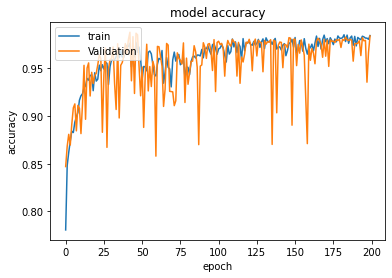

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()